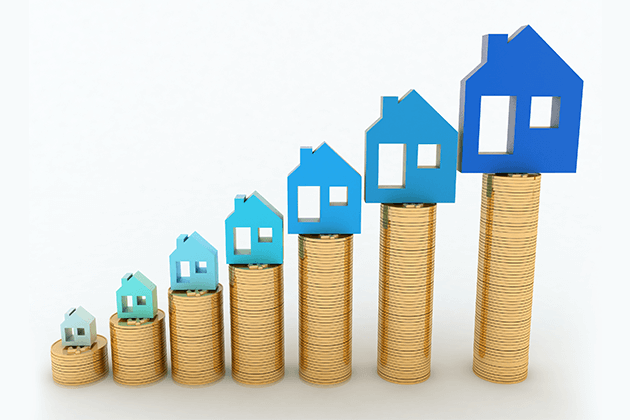

This notebook shows a very easy method of training, optimizing and blending models without writing too much code and without spending too much time looking for the best algorithms with the best hyper parameters.

The notebook is made up of two parts, the first is a mini data exploration in order to have an intuission on these, followed by a data engineering to eliminate null values and to add other values to make the dataset more explicit.

The second part is the moidelisation part with the PyCaret API which greatly facilitates the task.

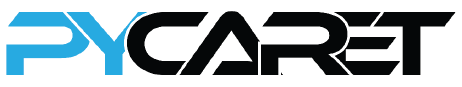

PyCaret is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within seconds in your choice of notebook environment.

To discover more functionality of pycaret I invite you to consult the official site <a href="https://pycaret.org/">pycaret</a>.

Reference to this notebook on which i was inspired : <a href="https://www.kaggle.com/frtgnn/pycaret-introduction-classification-regression">pycaret-introduction-classification-regression</a>. 

# Contents

* [<font size=4>Library and Data</font>](#1)
* [<font size=4>Train and Test Data Appearance</font>](#2)
* [<font size=4>Train Report</font>](#4)
* [<font size=4>Test Report</font>](#5)
* [<font size=4>Numeric Features Exploration</font>](#6)
* [<font size=4>Categorical Features Exploration</font>](#7)
* [<font size=4>Data Engineering</font>](#8)
* [<font size=4>Setting up Environment</font>](#9)
* [<font size=4>Compare Models</font>](#10)
* [<font size=4>Create and Train Models</font>](#11)
* [<font size=4>Models Tuning</font>](#12)
* [<font size=4>Display Learning Curve</font>](#13)
 *     [Bayesian Ridge](#13.1)
 *     [Gradient Boosting Regressor](#13.2)
 *     [Extreme Gradient Boosting](#13.3)
 *     [Ridge Regression](#13.4)
* [<font size=4>Blend Models</font>](#14)
* [<font size=4>Dsiplay Learning Curve for Blending</font>](#15)
* [<font size=4>Predict and Submit</font>](#16)

# Library and Data <a id="1"></a>

In [ ]:
!pip install pycaret

from pycaret.regression import *
import numpy as np 
import pandas as pd 
from pandas_profiling import ProfileReport 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_sample_submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
df_train['SalePrice'] = df_train['SalePrice'].astype(int)

pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

# Train and Test Data Appearance <a id="2"></a>

In [ ]:
print('\n \n First 5 row of Train Data : ')
display(df_train.head())

print('First 5 row of Test Data : ')
display(df_test.head())

# Train Report <a id="4"></a>

In [ ]:
report_train = ProfileReport(df_train)
report_train

# Test Report <a id="5"></a>

In [ ]:
report_test = ProfileReport(df_test)
report_test

# Numeric Features Exploration <a id="6"></a>

In [ ]:
index_int_float = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
        'LotFrontage', 'MasVnrArea', 'GarageYrBlt']

plt.figure(figsize=[20,12])
i = 1
for col in index_int_float :
    plt.subplot(4,10,i)
    sns.violinplot(x=col, data= df_train, orient='v')
    sns.despine()
    i = i+1
plt.tight_layout()
plt.show()
    

From these violinplot we can easily deduce that there are quite a few outliers in the lotArea, bsmtHalfBath, MiscVal and others features.

These Outliers will be treated by magic later.

# Categorical Features Exploration <a id="7"></a>

In [ ]:
index_str = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
        'LotFrontage', 'MasVnrArea', 'GarageYrBlt']

plt.figure(figsize=[30,10])
i = 1
for col in index_str :
    plt.subplot(4,10,i)
    sns.scatterplot(x=col, y = 'SalePrice' ,data= df_train)
    sns.despine()
    i = i+1
plt.tight_layout()
plt.show()

There is a strong positive linear relationship between GrLivArea, TotalBsmtSF, OverallQual and salePrice.

This is a good thing because at least there are features that can affect the price more or less.

# Data Engineering <a id="8"></a>

This data engineering I did it some time ago for an old notebook when I started on Kaggle,

It’s a notebook that introduces model stacking, model blending and model voting,

It can be viewed at the following link:  <a href="https://www.kaggle.com/servietsky/house-prices-voting-stacking-and-belnding">house-prices-voting-stacking-and-belnding"</a>. 

In [ ]:
df_test['SalePrice'] = 'test'
df = pd.concat([df_train, df_test])
df.drop(['Id'], axis=1, inplace = True)

df['PoolQC'].fillna('No Pool', inplace = True)
df['MiscFeature'].fillna('None', inplace = True)
df['Alley'].fillna('No alley access', inplace = True)
df['Fence'].fillna('No Fence', inplace = True)
df['FireplaceQu'].fillna('No Fireplace', inplace = True)
df['LotFrontage'].fillna(60.0, inplace = True)
df['GarageCond'].fillna('No Garage', inplace = True)
df['GarageType'].fillna('No Garage', inplace = True)
df['GarageYrBlt'].fillna(1890, inplace = True)
df['GarageFinish'].fillna('No Garage', inplace = True)
df['GarageQual'].fillna('No Garage', inplace = True)
df['BsmtExposure'].fillna('No Basement', inplace = True)
df['BsmtFinType2'].fillna('No Basement', inplace = True)
df['BsmtFinType1'].fillna('No Basement', inplace = True)
df['BsmtCond'].fillna('No Basement', inplace = True)
df['BsmtQual'].fillna('No Basement', inplace = True)
df['MasVnrArea'].fillna(0, inplace = True)
df['MasVnrType'].fillna('None', inplace = True)
# df['Exterior2nd'].fillna('None', inplace = True)
# df['Exterior1st'].fillna('None', inplace = True)
df['BsmtFullBath'].fillna(0, inplace = True) # df[df['BsmtFullBath'].isna()][['BsmtFullBath','BsmtFinType1','BsmtFinType2']]
df['BsmtHalfBath'].fillna(0, inplace = True) # df[df['BsmtFullBath'].isna()][['BsmtFullBath','BsmtFinType1','BsmtFinType2']]
# df['KitchenQual'].fillna(0, inplace = True)
  # df[(df['Neighborhood']== 'IDOTRR') | (df['Neighborhood']== 'Mitchel')]['MSZoning']
df.loc[(df['MSZoning'].isna()) & (df['Neighborhood'] == 'IDOTRR'), 'MSZoning'] = 'RM'
df.loc[(df['MSZoning'].isna()) & (df['Neighborhood'] == 'Mitchel'), 'MSZoning'] = 'RL'
df['Utilities'].fillna('AllPub', inplace = True) #la majorité
# df['BsmtHalfBath'].fillna(0.0, inplace = True) #la majorité
# df['BsmtFullBath'].fillna(0.0, inplace = True)
df['Functional'].fillna('Typ', inplace = True)
df['Exterior1st'].fillna('VinylSd', inplace = True)
df['Exterior2nd'].fillna('VinylSd', inplace = True)
df['TotalBsmtSF'].fillna(0, inplace = True)
df['BsmtUnfSF'].fillna(0, inplace = True)
df['BsmtFinSF2'].fillna(0, inplace = True)
df['GarageArea'].fillna(0, inplace = True)
df['GarageCars'].fillna(0, inplace = True)
df['KitchenQual'].fillna('TA', inplace = True)
df['BsmtFinSF1'].fillna(0, inplace = True)
df['SaleType'].fillna('WD', inplace = True)
df['Electrical'].fillna('SBrkr', inplace = True)
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['OverallCond'] = df['OverallCond'].astype(str)

print('Filling of Missing Data, Done.')

df['BsmtExposure'] = df['BsmtExposure'].map({'No Basement' : 0 ,'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4})
df['KitchenQual'] = df['KitchenQual'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['GarageYrBlt_Years'] =  abs(1890.0 - df['GarageYrBlt'])
df['YearBuilt_Years'] = abs(1872.0 - df['YearBuilt'])
df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)
df['YearBuilt'] = df['YearBuilt'].astype(str)

tmp = df['MoSold'].map({ 1: 0.0833, 2: 0.1666, 3: 0.25, 4: 0.3333, 5: 0.4166, 6: 0.50, 7: 0.5833, 8: 0.6666, 9: 0.75, 10: 0.8333
      , 11: 0.9166
      , 12: 0.9999})
df['YearSold'] = abs(2006.0 - (df['YrSold'] + tmp)).astype(float)
df['MoSold'] = df['MoSold'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)

criteria = [df['YearRemodAdd'] == df['YearBuilt'], df['YearRemodAdd'] != df['YearBuilt']]
values = [0, 1]

df['Remod'] = np.select(criteria, values, 0)
df['YearRemod'] = (df['YearRemodAdd'].astype(int) - df['YearBuilt'].astype(int)).astype(int)
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)
df['YearBuilt'] = df['YearBuilt'].astype(str)

df['Street'] = df['Street'].map({'Grvl': 0, 'Pave' : 1})
df['Alley'] = df['Alley'].map({'Grvl': 1, 'Pave' : 2 , 'No alley access' : 0 })
df['LotShape'] = df['LotShape'].map({'IR3': 0, 'IR2' : 1 , 'IR1' : 2 , 'Reg' : 3})
df['LandContour'] = df['LandContour'].map({'Low': 0, 'HLS' : 1 , 'Bnk' : 2 , 'Lvl' : 3})
df['Utilities'] = df['Utilities'].map({'ELO': 0, 'NoSeWa' : 1 , 'NoSewr' : 2 , 'AllPub' : 3})
# df['LotConfig'] = df['LotConfig'].map({'ELO': 0, 'NoSeWa' : 1 , 'NoSewr' : 2 , 'AllPub' : 3})
df['LandSlope'] = df['LandSlope'].map({'Gtl': 2, 'Mod' : 1 , 'Sev' : 0})

criteria = [
#AA
((df['Condition1'] == 'Artery') | (df['Condition1'] == 'RRAn') | (df['Condition1'] == 'PosA') | (df['Condition1'] == 'RRAe'))
&
((df['Condition2'] == 'Artery') | (df['Condition2'] == 'RRAn') | (df['Condition2'] == 'PosA') | (df['Condition2'] == 'RRAe'))
,
#AB
((df['Condition1'] == 'Artery') | (df['Condition1'] == 'RRAn') | (df['Condition1'] == 'PosA') | (df['Condition1'] == 'RRAe'))
&
((df['Condition2'] == 'Feedr') | (df['Condition2'] == 'RRNn') | (df['Condition2'] == 'PosN') | (df['Condition2'] == 'RRNe'))
,
#BA
((df['Condition2'] == 'Artery') | (df['Condition2'] == 'RRAn') | (df['Condition2'] == 'PosA') | (df['Condition2'] == 'RRAe'))
&
((df['Condition1'] == 'Feedr') | (df['Condition1'] == 'RRNn') | (df['Condition1'] == 'PosN') | (df['Condition1'] == 'RRNe'))
,
#BB
((df['Condition1'] == 'Feedr') | (df['Condition1'] == 'RRNn') | (df['Condition1'] == 'PosN') | (df['Condition1'] == 'RRNe'))
&
((df['Condition2'] == 'Feedr') | (df['Condition2'] == 'RRNn') | (df['Condition2'] == 'PosN') | (df['Condition2'] == 'RRNe'))
,
#A0
((df['Condition1'] == 'Artery') | (df['Condition1'] == 'RRAn') | (df['Condition1'] == 'PosA') | (df['Condition1'] == 'RRAe'))
&
(df['Condition2'] == 'Norm')
,
#0A
((df['Condition2'] == 'Artery') | (df['Condition2'] == 'RRAn') | (df['Condition2'] == 'PosA') | (df['Condition2'] == 'RRAe'))
&
(df['Condition1'] == 'Norm' )
,
#B0
((df['Condition1'] == 'Feedr') | (df['Condition1'] == 'RRNn') | (df['Condition1'] == 'PosN') | (df['Condition1'] == 'RRNe'))
&
(df['Condition2'] == 'Norm' )
,
#0B
((df['Condition2'] == 'Feedr') | (df['Condition2'] == 'RRNn') | (df['Condition2'] == 'PosN') | (df['Condition2'] == 'RRNe'))
&
(df['Condition1'] == 'Norm')
,
#00
(df['Condition1'] == 'Norm' )
&
(df['Condition2'] == 'Norm' )
]

values = [4,3,3,2,2,2,1,1,0]
df['conditions'] = np.select(criteria, values, 10)

df['Exterior2nd'] = df['Exterior2nd'].map({ 'AsbShng': 'AsbShng', 'AsphShn': 'AsphShn', 'Brk Cmn': 'BrkComm', 'BrkFace': 'BrkFace', 'CBlock': 'CBlock', 'CmentBd': 'CemntBd',
                       'HdBoard': 'HdBoard', 'ImStucc': 'ImStucc', 'MetalSd': 'MetalSd', 'Plywood': 'Plywood'
                      , 'Stone': 'Stone'
                      , 'Stucco': 'Stucco'
                      ,'VinylSd': 'VinylSd'
                      ,'Wd Sdng': 'Wd Sdng'
                      ,'Wd Shng': 'WdShing'
                      , 'None'  : 'None'
                      , 'Other' :  'Other'})

criteria = [
# Only 1
((df['Exterior1st'] == df['Exterior2nd']) | (df['Exterior2nd'] !=  'Other'))
,
# No One
(df['Exterior1st'] == 'None') &  (df['Exterior2nd'] == 'None')
,
# 2
(df['Exterior1st'] !=  df['Exterior2nd']) 
]

values = [1,0,2]
df['Exterior'] = np.select(criteria, values, 10)

criteria = [
# Have veneer 
(df['MasVnrType'] != 'None')
,
# Havnt veneer    
(df['MasVnrType'] == 'None')
]

values = [1,0]
df['veneer'] = np.select(criteria, values, 10)

df['ExterQual'] = df['ExterQual'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['ExterCond'] = df['ExterCond'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['BsmtQual'] = df['BsmtQual'].map({'No Basement' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5})

df['BsmtFinType1'] = df['BsmtFinType1'].map({'No Basement' : 0 ,'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ': 6})

df['BsmtFinType2'] = df['BsmtFinType2'].map({'No Basement' : 0 ,'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ': 6})

criteria = [
# No Bsmt
(df['BsmtFinType1'] == 0) & (df['BsmtFinType2'] == 0)
,
# 1 Bsmt   
((df['BsmtFinType1'] != 0) & (df['BsmtFinType2'] != 0) & (df['BsmtFinType1'] == df['BsmtFinType2']))
|
((df['BsmtFinType1'] != 0) & (df['BsmtFinType2'] == 0))
|
((df['BsmtFinType1'] == 0) & (df['BsmtFinType2'] != 0)) 
,
# 2 bsmnt
(df['BsmtFinType1'] != 0) & (df['BsmtFinType2'] != 0) & (df['BsmtFinType1'] != df['BsmtFinType2'])
]

values = [0,1,2]
df['Bsmt'] = np.select(criteria, values, 10)

df['HeatingQC'] = df['HeatingQC'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['CentralAir'] = df['CentralAir'].map({'N' : 0 ,'Y' : 1})

df['FireplaceQu'] = df['FireplaceQu'].map({'No Fireplace' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4 , 'Ex' : 5})

df['Functional'] = df['Functional'].map({'Sal' : 0 ,'Sev' : 1, 'Maj2' : 2, 'Maj1' : 3, 'Mod' : 4 , 'Min2' : 5, 'Min1' : 6, 'Typ' : 7})

criteria = [
# No garage
df['GarageType'] == 'No Garage'
,
#2 garages
df['GarageType'] == '2Types'
,
# only one garage
(df['GarageType'] != '2Types') & (df['GarageType'] != 'No Garage')
]

values = [0,2,1]
df['Garage'] = np.select(criteria, values, 10)

df['GarageFinish'] = df['GarageFinish'].map({'No Garage' : 0 ,'Unf' : 1, 'RFn' : 2, 'Fin' : 3})

df['GarageQual'] = df['GarageQual'].map({'No Garage' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4 , 'Ex' :5})

df['GarageCond'] = df['GarageCond'].map({'No Garage' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4 , 'Ex' :5})

df['PavedDrive'] = df['PavedDrive'].map({'N' : 0 ,'P' : 1, 'Y' : 2})

df['PoolQC'] = df['PoolQC'].map({'No Pool' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['Fence'] = df['Fence'].map({'No Fence' : 0 ,'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4})

criteria = [
# No Feature
df['MiscFeature'] == 'None'
,
# with Feature
df['MiscFeature'] != 'None'
]
values = [0,1]
df['Feature'] = np.select(criteria, values, 10)
df['TotalArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] +df['GarageArea']
df['Bathrooms'] = df['FullBath'] + df['HalfBath']*0.5 
df['Year average']= (df['YearRemodAdd'].astype(int)+df['YearBuilt'].astype(int))/2

df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df_train.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1

print('Adding New Features, Done.')

df_train = df[df['SalePrice'] != 'test']
df_test = df[df['SalePrice'] == 'test']
df_train['SalePrice'] = df_train['SalePrice'].astype(float)

# to reduce the skewness of the saleprice it is necessary to apply the logarithm function on the saleprice. 
# More details are on this notebook: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
df_train['SalePrice'] =  np.log(df_train['SalePrice'])
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

df_test['GrLivArea'] = np.log(df_test['GrLivArea'])
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

print('Adjustment of Skewness, Done.')

# Setting up Environment <a id="9"></a>

In [ ]:
int_features = ['LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LandSlope', 'OverallQual', 'ExterQual', 'ExterCond', 'BsmtQual',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
        'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'PoolQC', 'Fence', 'MiscVal', 'Remod', 'YearRemod',
        'conditions', 'Exterior', 'veneer', 'Bsmt', 'Garage', 'Feature',
        'HasBsmt']

float_feartues = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
        'GarageCars', 'GarageArea', 'GarageYrBlt_Years', 'YearBuilt_Years',
        'YearSold', 'TotalArea', 'Bathrooms', 'Year average']

obj_features = ['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'BsmtCond', 'Heating', 'Electrical',
        'GarageType', 'GarageYrBlt', 'MiscFeature', 'MoSold', 'YrSold',
        'SaleType', 'SaleCondition']

exp_reg = setup(df_train, #Train Data
                target = 'SalePrice',  #Target
                categorical_features = obj_features, # Categorical Features
                numeric_features = int_features + float_feartues, # Numeric Features
                normalize = True, # Normalize Dataset
                remove_outliers = True, # Remove 5% Outliers
                remove_multicollinearity = True, # Remove Multicollinearity
                silent = True # Process Automation
               )

# Compare Models <a id="10"></a>

In [ ]:
compare_models(blacklist = ['tr', 'catboost'], sort = 'RMSLE')

# Create and Train Models <a id="11"></a>

In [ ]:
model_br = create_model('br')
model_lightgbm = create_model('lightgbm')
model_xgboost = create_model('xgboost')
model_ridge = create_model('ridge')

# Models Tuning <a id="12"></a>

In [ ]:
tuned_br = tune_model('br')
tuned_lightgbm = tune_model('lightgbm')
tuned_xgboost = tune_model('xgboost')
tuned_ridge = tune_model('ridge')

# Display Learning Curve <a id="13"></a>

## Bayesian Ridge <a id="13.1"></a>

In [ ]:
plot_model(tuned_br, plot = 'learning')

## Gradient Boosting Regressor <a id="13.2"></a>

In [ ]:
plot_model(tuned_lightgbm, plot = 'learning')

## Extreme Gradient Boosting <a id="13.3"></a>

In [ ]:
plot_model(tuned_xgboost, plot = 'learning')

## Ridge Regression <a id="13.4"></a>

In [ ]:
plot_model(tuned_ridge, plot = 'learning')

# Blend Models <a id="14"></a>

In [ ]:
blender = blend_models(estimator_list = [tuned_br, tuned_lightgbm, tuned_xgboost, tuned_ridge])

# Dsiplay Learning Curve for Blending <a id="15"></a>

In [ ]:
display(plot_model(blender, plot = 'learning'))

# Predict and Submit <a id="16"></a>

In [ ]:
predictions = predict_model(blender, data = df_test)
df_sample_submission['SalePrice'] = np.expm1(predictions['Label'])
df_sample_submission.to_csv('submission.csv',index=False)

<center>
  <FONT size="10" color = 'red'>Thank you, I hope you enjoyed. Upvote that helps me a lot =)</FONT>
</center>

I made another notebook using the same method for classification, it can be viewed from this link: 
<a href="https://www.kaggle.com/servietsky/easy-way-titanic-pycaret">easy-way-titanic-pycaret</a>. Enjoy <3